In [2]:
include("./modules/OpticalCavity.jl")
include("./modules/Thermodynamics.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using SparseArrays
using Expokit
using ProgressBars
using Plots
using LaTeXStrings
# Saving the output matrix
using Serialization
using ProfileVega

using .OpticalCavity
using .Thermodynamics
using .Phaseonium
using .BosonicOperators
using .Measurements

include("./src/RoutineFunctions.jl")

In [3]:
function bosonic_operators(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    return [C, Cp, S, Sd]
end

function adiabaticevolve_2(ρ, cavities, Δt, timesteps, allocated_op, π_parts)
    h, U, idd = allocated_op
    n, π_a, π_ad = π_parts
    
    Δt² = Δt^2  

    c1, c2 = cavities
    α0 = c1.α

    # a1 = c1.acceleration
    # a2 = c2.acceleration
    a1 = 0  # Cavities are fixed until this time
    a2 = 0
    
    for t_idx in 0:timesteps
        t = t_idx * Δt
        # Move the cavity wall
        c1.length += 0.5 * a1 * Δt²
        c2.length += 0.5 * a2 * Δt²
        # Update energies
        ω₁ = α0 / c1.length
        ω₂ = α0 / c2.length
        h1 = 0.5 * ω₁ .* n
        h2 = 0.5 * ω₂ .* n
        h = kron(h1, h2)
        # Evolve the System
        U .= padm(-im .* h)
        ρ = U * ρ * U'
        # Update pressure and acceleration
        π₁ = (2 * n .+ 1)  - (π_a * exp(-2*im*ω₁*t)) - (π_ad * exp(2*im*ω₁*t))
        π₂ = (2 * n .+ 1)  - (π_a * exp(-2*im*ω₂*t)) - (π_ad * exp(2*im*ω₂*t))
        p1 = Measurements.pressure(ρ, π₁, idd, α0, c1.length, c1.surface; s=1)
        p2 = Measurements.pressure(ρ, π₂, idd, α0, c2.length, c2.surface; s=2)
        a1 = (p1 * c1.surface - c1.external_force) / c1.mass
        a2 = (p2 * c2.surface - c2.external_force) / c2.mass
    end
  
    c1.acceleration = a1
    c2.acceleration = a2

    return ρ, c1, c2
end

function adiabaticevolve_22(ρ, cavities, Δt, timesteps, allocated_op, π_parts)
    U, idd = allocated_op
    n, π_a, π_ad = π_parts
    
    Δt² = Δt^2  

    c1, c2 = cavities
    α0 = c1.α

    a1 = c1.acceleration
    a2 = c2.acceleration
    
    for t_idx in 0:timesteps
        t = t_idx * Δt
        # Move the cavity wall
        c1.length += 0.5 * a1 * Δt²
        c2.length += 0.5 * a2 * Δt²
        # Update energies
        ω₁ = α0 / c1.length
        ω₂ = α0 / c2.length
        h1 = 0.5 * ω₁ .* n
        h2 = 0.5 * ω₂ .* n
        h = kron(h1, h2)
        # Evolve the System
        U .= padm(-im .* h)
        ρ = U * ρ * U'
        # Update pressure and acceleration
        π₁ = (2 * n + idd)  - (π_a * exp(-2*im*ω₁*t)) - (π_ad * exp(2*im*ω₁*t))
        π₂ = (2 * n + idd)  - (π_a * exp(-2*im*ω₂*t)) - (π_ad * exp(2*im*ω₂*t))
        p1 = Measurements.pressure(ρ, π₁, idd, α0, c1.length, c1.surface; s=1)
        println("p1: $p1")
        p2 = Measurements.pressure(ρ, π₂, idd, α0, c2.length, c2.surface; s=2)
        println("p2: $p2")
        a1 = (p1 * c1.surface - c1.external_force) / c1.mass
        a2 = (p2 * c2.surface - c2.external_force) / c2.mass
    end
  
    c1.acceleration = a1
    c2.acceleration = a2

    return ρ, c1, c2
end

adiabaticevolve_22 (generic function with 1 method)

In [11]:
const NDIMS = 10
const Ω = 1.0
const Δt = 1e-2

const T_initial = 1.0
const T_heating = 1.2
const T_cooling = 0.7

# Create a Cavity
const α0 = π
const l0 = 1.0
const expanding_force = 0.5
const compressing_force = 2.5
cavity1 = Cavity(1.0, 1.0, l0, α0, expanding_force)
cavity2 = Cavity(1.0, 1.0, l0, α0, expanding_force)
ω = α0 / l0

ρt = thermalstate(NDIMS, ω, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω))")
# Joint system
ρ_tot = kron(ρt, ρt)

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating
ϕ_h = π/3
α_h = Phaseonium.alpha_from_temperature(T_heating, ϕ_h, ω) 

const ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_h, gb_h))")

bosonic_h = bosonic_operators(α_h, ϕ_h)

# Cooling
ϕ_c = π/4
α_c = Phaseonium.alpha_from_temperature(T_cooling, ϕ_c, ω) 

const ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_c, gb_c))")

bosonic_c = bosonic_operators(α_c, ϕ_c)
;

Initial Temperature of the Cavity:
    1.0
Apparent Temperature carried by Hot Phaseonium atoms: 
    1.2
Apparent Temperature carried by Cold Phaseonium atoms: 
    0.7


0.0016360518981850076
2.6766658135547665e-6
1.1248586349650822


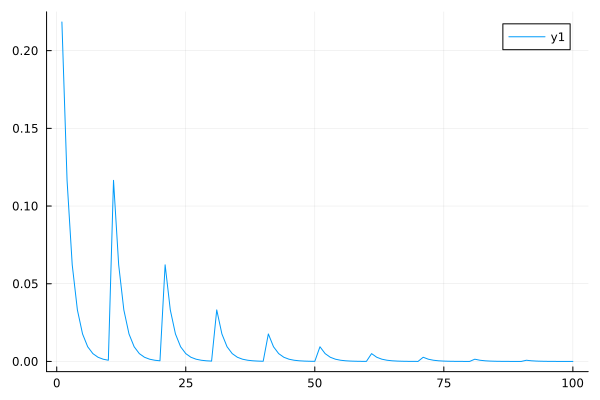

In [12]:
# How many dimensions do we need?
ndims = 10
tstate = thermalstate(ndims, ω, 5)
txtstate = kron(tstate, tstate)
println(tstate[end])
println(txtstate[end])
# Jump Operators
a = BosonicOperators.destroy(ndims)
ad = BosonicOperators.create(ndims)
n_photons = tr(tstate * ad * a)
println(n_photons)
g1 = heatmap(1:ndims^2, 1:ndims^2, txtstate)
g2 = plot(1:ndims^2, diag(txtstate))

### Load or Create State

In [13]:
# Check number of photons and cutoff
println(tr(ρt*ad*a))
println(ρt[end])

0.045165705363457
5.028375069174158e-13


In [14]:
ndims = 10

rho1 = thermalstate(ndims, ω, 1.5)
println("N1 = $(tr(rho1*ad*a))")
rho2 = thermalstate(ndims, ω, 1)
println("N2 = $(tr(rho2*ad*a))")

identity_matrix = spdiagm(ones(ndims))
n = ad * a
π_a = a * a
π_ad = ad * ad

πOp = (2 * n + identity_matrix)  - (π_a * exp(-2*im*ω)) - (π_ad * exp(2*im*ω))
p1 = Measurements.pressure(rho1, πOp, identity_matrix, α0, l0, 1.0)
println("P1 = $p1")
p2 = Measurements.pressure(rho2, πOp, identity_matrix, α0, l0, 1.0)
println("P2 = $p2")

N1 = 0.14043902750283122
N2 = 0.045165705363457
P1 = 2.0119985438750865
P2 = 1.7126885749589342


### Cycle

In [15]:
ρ = kron(ρt, ρt)
isochore_time = 8000
isochore_samplings = 25
adiabatic_time = 5000
adiabatic_samplings = 25

total_cycle_time = isochore_samplings * 2 + 2 * adiabatic_samplings + 4

104

In [16]:
ρ_f = convert(SparseMatrixCSC{ComplexF64, Int64}, ρ)
# Operators are defined on one subspace
dims = Int(sqrt(size(ρ)[1]))
identity_matrix = spdiagm(ones(dims))
# Reduce precision
a = convert(SparseMatrixCSC{Float32, Int64}, a)
ad = convert(SparseMatrixCSC{Float32, Int64}, ad)
# Pressure Operator
# Decomposed in three parts (constant and rotating)
n = ad * a
π_a = a * a
π_ad = ad * ad
π_parts = (n, π_a, π_ad) 

# Preallocate variables with reduce precision
π₁, π₂ = spzeros(ComplexF32, size(n)...), spzeros(ComplexF32, size(n)...)
h = spzeros(Float32, size(ρ)...)
U = spzeros(ComplexF32, size(ρ)...)
# ρ = convert(SparseMatrixCSC{ComplexF32, Int64}, ρ)  # Convert real sparse matrix to complex sparse
alloc = (h, U, identity_matrix, π₁, π₂);

In [24]:
alloc = (h, U, identity_matrix)
@benchmark adiabaticevolve_2($ρ_f, $(cavity, cavity), $Δt, 1, $alloc, $π_parts)

BenchmarkTools.Trial: 573 samples with 1 evaluation.
 Range (min … max):  4.152 ms … 53.934 ms  ┊ GC (min … max): 0.00% … 78.59%
 Time  (median):     8.118 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.716 ms ±  3.517 ms  ┊ GC (mean ± σ):  9.24% ±  9.92%

        ▂▄▄▃▆▆▅█▆▄ ▄▃▁▃ ▄                                     
  ▄▅▄▆▇████████████████▇█▆█▆▇▄▄▄▄▆▃▄▃▄▂▂▃▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▃ ▄
  4.15 ms        Histogram: frequency by time          20 ms <

 Memory estimate: 9.19 MiB, allocs estimate: 542.

p1: 1.712688574683477
p2: 1.7126885746834772
p1: 1.7124808984033764
p2: 1.7124808984033768


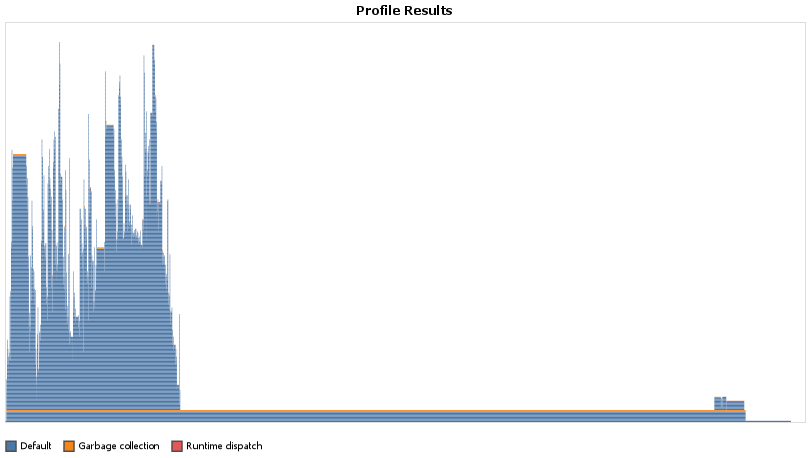

In [17]:
alloc = (U, identity_matrix)
@profview adiabaticevolve_22(ρ_f, (cavity1, cavity2), Δt, 1, alloc, π_parts)